In [1]:
'''  **Concept:** Take a small dataset of text (e.g., steam game reviews) and use a pre-trained model (like a simple text classifier) 
to determine the sentiment (positive, negative, or neutral).
'''

# Imports and setup

# C:\Users\icecr\.kaggle\kaggle.json
import kaggle, kagglehub, os, json, sklearn, math
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from collections import defaultdict
from sklearn import preprocessing
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from kagglehub import KaggleDatasetAdapter
import nltk, string, re, inflect
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from num2words import num2words


In [2]:
# Check if archive.zip exists
import os

print(os.listdir("/Users/icecr/.kaggle/"))  # Lists files in the directory


['archive.zip', 'game_overview.csv', 'kaggle.json', 'sentiment-analysis-for-steam-reviews.zip', 'train.csv']


In [3]:
import os

print(os.getenv("KAGGLE_CONFIG_DIR"))  


C:\Users\icecr\.kaggle\


In [4]:
# Unzip the dataset

import zipfile

with zipfile.ZipFile("/Users/icecr/.kaggle/archive.zip", 'r') as zip_ref:
    zip_ref.extractall("/Users/icecr/.kaggle/")


In [5]:
# Load and verify dataset

# Loading the dataset
df = pd.read_csv("/Users/icecr/.kaggle/train.csv")

# Print the first 5 records
print("First five records: ", df.head())


First five records:     review_id                        title    year  \
0          1  Spooky's Jump Scare Mansion  2016.0   
1          2  Spooky's Jump Scare Mansion  2016.0   
2          3  Spooky's Jump Scare Mansion  2016.0   
3          4  Spooky's Jump Scare Mansion  2015.0   
4          5  Spooky's Jump Scare Mansion  2015.0   

                                         user_review  user_suggestion  
0  I'm scared and hearing creepy voices.  So I'll...                1  
1  Best game, more better than Sam Pepper's YouTu...                1  
2  A littly iffy on the controls, but once you kn...                1  
3  Great game, fun and colorful and all that.A si...                1  
4  Not many games have the cute tag right next to...                1  


In [6]:
# Gather a quick description of the data

df.info()

# no missing features as we can see, there are 17494 of user_review and user_suggestion, which takes up the whole dataset


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17494 entries, 0 to 17493
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   review_id        17494 non-null  int64  
 1   title            17494 non-null  object 
 2   year             17316 non-null  float64
 3   user_review      17494 non-null  object 
 4   user_suggestion  17494 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 683.5+ KB


In [7]:
# Dropping irrelevant columns, and keeping user_review and user_suggestion

df.drop(['review_id', 'title', 'year'], axis=1, inplace=True)


user_suggestion
0    7526
1    9968
dtype: int64


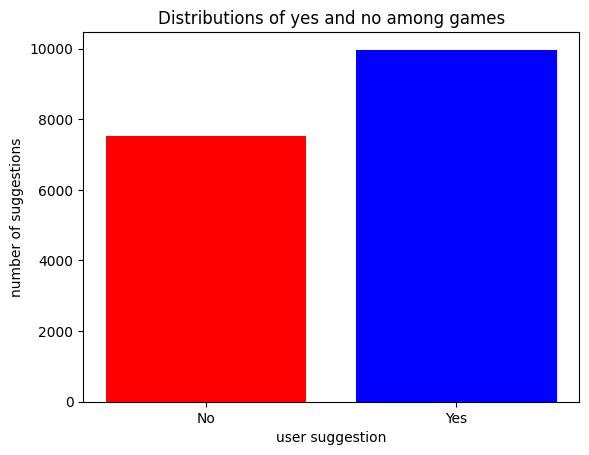

In [8]:
# Visualize the data with bar plot
# x-val should be unique category values ('Yes' or 'No') and y-val are review 

import matplotlib.pyplot as plt

GroupedData=df.groupby(by='user_suggestion').size()         # yes (1) or no (0) in user_suggestion
print(GroupedData)

categories = ['No', 'Yes']
values = GroupedData.values     # outputs an array [7526 9968] for the y-axis

plt.bar(categories, values, color=['red', 'blue'])
plt.title('Distributions of yes and no among games')
plt.xlabel('user suggestion')
plt.ylabel('number of suggestions')
plt.show()

# 7526 + 9968 = 17494 data values. which equals the number of games
# text sentiment will be mostly positive.


In [9]:
print(df.shape)
print(df.columns)


(17494, 2)
Index(['user_review', 'user_suggestion'], dtype='object')


In [10]:
# Splitting the dataset into training, validation, and testing

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# head of the data
print('Head of the dataframe : ')
print(df.head())

X = df[['user_review']]
y = df[['user_suggestion']]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42, test_size=0.2, shuffle=True
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, random_state=42, test_size=0.25, shuffle=True
)

# printing out train, validation, and.
# test sets

print('X_train : ')
print(X_train.head())
print(X_train.shape)

print('')
print('X_test : ')
print(X_test.head())
print(X_test.shape)

print('')
print('y_train : ')
print(y_train.head())
print(y_train.shape)

print('')
print('y_test : ')
print(y_test.head())
print(y_test.shape)

print('X_train : ')
print(X_train.head())
print(X_train.shape)

print('')
print('X_val : ')
print(X_val.head())
print(X_val.shape)

print('')
print('y_train : ')
print(y_train.head())
print(y_train.shape)

print('')
print('y_val : ')
print(y_val.head())
print(y_val.shape)


Head of the dataframe : 
                                         user_review  user_suggestion
0  I'm scared and hearing creepy voices.  So I'll...                1
1  Best game, more better than Sam Pepper's YouTu...                1
2  A littly iffy on the controls, but once you kn...                1
3  Great game, fun and colorful and all that.A si...                1
4  Not many games have the cute tag right next to...                1
X_train : 
                                             user_review
10386  If you don't mind investing $20 or so to get y...
17043  Early Access Reviewi didnt end up playing the ...
9889   At first i love Elsword, it was a cute side sc...
7371   SALTMatchmaking and deck balance appears funda...
13930  Nope. 1st spawn in on beginner server: shot by...
(10496, 1)

X_test : 
                                            user_review
2701  =Old Review, 2014=  Great primarily WWII era m...
1944  This is a trash game:missing middle, missing m...
247   Early 

In [11]:
import pandas as pd
'''

# Assuming your dataset is split into train and test DataFrames
X_train.to_csv("train_data.csv", index=False)
X_val.to_csv("val_data.csv", index=False)

'''


'\n\n# Assuming your dataset is split into train and test DataFrames\nX_train.to_csv("train_data.csv", index=False)\nX_val.to_csv("val_data.csv", index=False)\n\n'

In [12]:
# Preprocessing Step 1
# Converting user_review column into lowercase

print(X_train.dtypes)

print(X_train['user_review'].dtype)
print(X_train['user_review'].head())

# Convert user reviews to string and lowercase
X_train['user_review'] = X_train['user_review'].astype(str).str.lower()  
X_val['user_review'] = X_val['user_review'].astype(str).str.lower()  

print(X_train['user_review'].head())
print(X_val['user_review'].head())


user_review    object
dtype: object
object
10386    If you don't mind investing $20 or so to get y...
17043    Early Access Reviewi didnt end up playing the ...
9889     At first i love Elsword, it was a cute side sc...
7371     SALTMatchmaking and deck balance appears funda...
13930    Nope. 1st spawn in on beginner server: shot by...
Name: user_review, dtype: object
10386    if you don't mind investing $20 or so to get y...
17043    early access reviewi didnt end up playing the ...
9889     at first i love elsword, it was a cute side sc...
7371     saltmatchmaking and deck balance appears funda...
13930    nope. 1st spawn in on beginner server: shot by...
Name: user_review, dtype: object
17440    la verdad, quisiera poder decir algo de este j...
14758    early access reviewwant a short review? okay.r...
14135    infestation: survivor stories was by far my fa...
16395    faithful people of the tsar today is a terrify...
6622     early access reviewone rocket? thats 450 credi...
Name: 

In [13]:
# Preprocessing Step 2

# Converting all numbers into text
# Adds spaces after special characters and words

import re
from num2words import num2words

def filter_numbers(text):
    # Apply regex replacements before splitting words
    text = re.sub(r":(\S)", r": \1", text)  # Adds space after colons
    text = re.sub(r"\?(\S)", r"? \1", text)  # Adds space after question marks
    text = re.sub(r"(?<!\d)\.(?=[A-Za-z])", ". ", text) # Adds space after periods before letters, unless preceded by a digit
    text = re.sub(r"(?=\d)\'(?=[Ss])", "' ", text) # Splits 1990's into 1990 s
    text = re.sub(r"(?<=\d)\.(?=[STst])", " ", text)  # Expected: "1 st 2nd 3rd 4th, 1 st 2 st"
    
    words = text.split()  # Split text into words
    filtered_words = []

    for word in words:
        if re.match(r'^\d{4}$', word):  # Matches numbers with 4+ digits
            formatted_year = num2words(word, to='year')
            filtered_words.append(formatted_year + 's')  # 1990 to ninteen ninetys
        
        
        elif re.match(r'\d+$', word):  
            filtered_words.append(num2words(int(word)))
            continue
        
        elif re.match(r'^\d+(st|nd|rd|th)$', word, re.IGNORECASE):  # Matches ordinal numbers
            num_part = re.match(r'^\d+', word).group()  # Extracts the numeric portion
            ordinal_text = num2words(int(num_part), to='ordinal')  # Convert to word format
            filtered_words.append(ordinal_text)  # Append properly formatted text
        
        else:
            # Preserve everything else (keeps unchanged words)
            filtered_words.append(word)

    return " ".join(filtered_words)  

# Apply filtering
X_train['user_review'] = X_train['user_review'].apply(filter_numbers)
X_val['user_review'] = X_val['user_review'].apply(filter_numbers) 

print(X_train['user_review'].iloc[7])
print('\n')
print(X_val['user_review'].iloc[32])


the single player mode can, for the most part, be played on auto mode. i managed to get to the eighth stage with very little input outside of periodic monster selection and arrangement. there is plenty to do though, and the real strategy will be required in pvp. there's plenty of opportunity to earn cards and i have managed to grab mostly wins in pvp without spending any money. edit: as i've played further it's become impossible to use auto mode and the game requires more thought. i also appreciate the periodic free gems and general updates.


avoid at all costs: if you can even get the registation to work, trove requires you to register with and use a seperate launcher, which, at registration, asks for a bunch of details that no game on steam should need. using the registration link from the launcher doesn't work - it opens a registration page in your default browser, which doesn't actually do anything, and will not allow you to register (if you use firefox, it won't even have the inp

In [14]:
# Preprocessing Step 3
# Removing punctuation
import string

def remove_punctuation(text):
    if not isinstance(text, str):
        return text  
    
    # Remove punctuation
    translator = str.maketrans('', '', string.punctuation)
    clean_text = text.translate(translator)
    
    clean_text = ' '.join(clean_text.split())
    return clean_text

X_train['user_review'] = X_train['user_review'].apply(remove_punctuation)
X_val['user_review'] = X_val['user_review'].apply(remove_punctuation)

print(X_train['user_review'].iloc[22])
print('\n')
print(X_val['user_review'].iloc[10])


very very good design i feel tho if they had charged something like twenty bux and had severely limited the pay to win aspect they would have done better at least reputation wise however when it first came out i maxed out my level and came about 70 the max dps with just good grinding from there on its very steep pay to win or was havent played in some time bc of that good game tho id say it should be redone better graphics new more engaging world and a better loot structure less pay to win


heroes generals is a game with much potential or rather had much potential a while ago hell id even say the game is quite good but its the developers and the insane grind that ruin this game if you want any info on why the devs are completely awful i reckon you can just read another review that is negative and see what i mean but the reason this game was ruined for me personally was the insane grind that comes with the game this game is not free2play its pay2win and thats a shame because the core c

In [15]:
# Preprocessing Step 4
# Removing special characters

import re

def remove_special_characters(text):
    if not isinstance(text, str):
        return text
    
    return re.sub(r'[\W+]', ' ', text)

        
X_train['user_review'] = X_train['user_review'].apply(remove_special_characters)
X_val['user_review'] = X_val['user_review'].apply(remove_special_characters)

print(X_train['user_review'].iloc[22])
print('\n')
print(X_val['user_review'].iloc[19])


very very good design i feel tho if they had charged something like twenty bux and had severely limited the pay to win aspect they would have done better at least reputation wise however when it first came out i maxed out my level and came about 70 the max dps with just good grinding from there on its very steep pay to win or was havent played in some time bc of that good game tho id say it should be redone better graphics new more engaging world and a better loot structure less pay to win


the latest update module 6 marked the demise of neverwinter the often ptw mrpg is now fubar characters are nerfed and opponents buffed in an attempt to get you to buy too much too soon too bad


In [16]:
# Preprocessing Step 5
# Converting ALL numbers to words

from num2words import num2words

def numbers_to_words(text):
    if isinstance(text, int):
        return num2words(text)
    
    elif isinstance(text, str):
        return " ".join([num2words(int(word)) if word.isdigit() else word for word in text.split()])
    return text
    
X_train['user_review'] = X_train['user_review'].apply(numbers_to_words)
X_val['user_review'] = X_val['user_review'].apply(numbers_to_words)

print(X_train['user_review'].iloc[21])
print('\n')
print(X_val['user_review'].iloc[150])


its a nice game and ive always been a fan of the btd series as for in game purchases i cant say its exactly the same when you buy energy it gives it to you but does not increase your actual max cap which it does seem so i kind of just got scammed out of one hundred and ninety-nine not that its that much but for what it was worth it was a complete waste and i am quite upset about this after all i dont recommend wasting a lot of money on this game because usually you wouldnt get a steam card every single day at least i dont overall its a very fun game just like all of the other btd games


the hunter let me start by saying that the ammount of hours ive accumulated on steam does not resemble my time ingame for i started playing before this game was on steam now to my opinion of the hunter its a free game in the sense that this free game lets you have a peak at the game before investing anything into it people these days expect everything for nothing this is not how it is sadly for those t

In [17]:
# Preprocessing Step 6
# Remove '-' in between numbers and remove words or letters that exceed a certain length

import re
import string

def clean_text(text, max_word_length=20):
    if not isinstance(text, str):
        return text
    
    text = re.sub(r'\b(\w+)-(\w+)\b', r'\1 \2', text)
    words = [word for word in text.split() if len(word) <= max_word_length]
    
    return " ".join(words)

X_train['user_review'] = X_train['user_review'].apply(lambda x: clean_text(x))
X_val['user_review'] = X_val['user_review'].apply(lambda x: clean_text(x))

print(X_train['user_review'].iloc[22])
print('\n')
print(X_val['user_review'].iloc[150])


very very good design i feel tho if they had charged something like twenty bux and had severely limited the pay to win aspect they would have done better at least reputation wise however when it first came out i maxed out my level and came about seventy the max dps with just good grinding from there on its very steep pay to win or was havent played in some time bc of that good game tho id say it should be redone better graphics new more engaging world and a better loot structure less pay to win


the hunter let me start by saying that the ammount of hours ive accumulated on steam does not resemble my time ingame for i started playing before this game was on steam now to my opinion of the hunter its a free game in the sense that this free game lets you have a peak at the game before investing anything into it people these days expect everything for nothing this is not how it is sadly for those the hunter is an absolutely gorgeous game so far the best in simulating a real hunting envirom

In [18]:
# Preprocessing Step 7
# Removing URLs from strings
# http oi64 tinypic com34rfxv5jpg iloc train 281

import re

def remove_urls(text, replacement_text=''):
    # Define a regex pattern to match URLs
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    if not isinstance(text, str):
        return text
    
    # Use the sub() method to replace URLs with the specified replacement text
    text_without_urls = url_pattern.sub(replacement_text, text)

    return text_without_urls

X_train['user_review'] = X_train['user_review'].apply(remove_urls)
X_val['user_review'] = X_val['user_review'].apply(remove_urls)

print(X_train['user_review'].iloc[454])
print('\n')
print(X_val['user_review'].iloc[200])


i thought i will never play this game again i was wrong this game this game is awsome it is been three years when i log insystem says that i had gain 520o three years


my suggestionfirst of all is it worth it downloading it really is it is free and also small in size it is really addictive so i suggest you download it what do i do in this game it is a 2d fighter game in the online mode you can fight in 2v2s and 1v1s and also a free for all which can hold four people it is like a koth king of the hill game but with a twist every player has a damage bar the redder it is the more knockback the player takes it has alot of modes the main one is the one with stocks usually three stocks stocks lives you can also use thons of characters you need to buy them can i play with my friend yes you can if you want to host your own custom room you can play with seven other people but you cannot play ranked with more then two people overall rating nine hundred and ten i hope this helped a lot of you pe

In [19]:
# Preprocessing Step 8
# Removing numbers from abbreviations then putting them back as words 
# > p2w becomes pay to win, tf2 becomes team fortress two, etc.

import re
import string
    
def abbreviation_to_word(text):
    replacements = {
        'aq': 'adventure quest',
        'aqw' : 'adventure quest worlds',
        'f2p' : 'free to play',
        'free2play' : 'free to play',
        'tf2' : 'team fortress two',
        'pvp' : 'player versus player',
        'p2w' :  'pay to win',
        'pay2win' : 'pay to win',
        'bl2' : 'borderlands two',
        '2d'  : 'two dimensional',
        '3d' : 'three dimensional',
        'ww2' : 'world war two',
        '25d' : '25 days',
        '24h' : '24 hours',
        'dota2' : 'defense of the ancients two',
        'c2p'   :   'cheap to play',
        'ww12'  :   'world war one two',
        'pay2win'   : 'pay to win',
        '12v2'  :   'twelve versus two',
        'd1' : 'diablo one',
        'd2'    :   'diablo two',
        'smb4'  :   'super smash bros four',
        '1k'    : 'one thousand',
        '2k'    : 'two thousand',
        'fc3'   : 'flaming cliffs three',
        'f15c':      'f fifteen eagle',
        'su27':      'sukhoi su twenty seven',
        '79g':       "seventy nine g force",
        "1200p":     "one thousand two hundred pixel resolution",
        '1v1'   :   'one versus one',
        '2v2'   :   'two versus two',
        'dcs'   :   'digital combat simulator',
        'ghz'   :   'gigahertz',
        '32g'   :   'thirty two gigabytes',
        'roomie' :  'roommate',
        'mtx'   :   'microtransactions',
        'dev'   :   'development',
        'ui': 'user interface',
        'pc' : 'personal computer',
        'mac' : 'macintosh',
        'rts' : 'real time strategy',
        'mmo' : 'massively multiplayer online',
        'mmorpg': 'massively multiplayer online roleplaying game',
        'ccg' : 'collectible card game',
        'br' : 'battle royale',
        'fps' : 'first person shooter',
        'smg' : 'submachine gun',
        'perma' : 'permanent',
        'rr3' : 'real racing three',
        'dm' : 'driving mode',
        'dlc' : 'downloadable content',
        'xbox 360' : 'xbox three sixty',
        'ps1' : 'playstation one',
        'ps2' : 'playstation two',
        'ps3' : 'playstation three',
        'ps4' : 'playstation four',
        'i7 4770k' : 'intel core i seven four thousand and seven hundred and seventy k processor  with unlocked multiplier',
        '200m' : 'two hundred meter',
        'niece310' : 'nice',
        'anymore50h' : 'anymore',
        'h2back' : 'back',
        '1h' : 'one hour',
        '910graphics' : 'graphics',
        '910sound' : 'sound',
        '710story' : 'story',
        '610controls' : 'controls',
        'hilarious2' : 'hilarious',
        '100s' : 'hundreds',
        'n00b' : 'noob',
        'under1' : 'under',
        'syncing2' : 'syncing',
        '1010' : 'ten out of ten',
        'ai' : 'artificial intelligence',
        'f2pp2p' : 'free to play',
        'alts' : 'alternatives',
        'asap' : 'as soon as possible',
        '610cartoony' : 'cartoony',
        't10' : 'tier ten',
        'tx1' : 'technology experimental one',
        'ffb' : 'force feedback',
        '1x1' : 'one times one',
        'rpg' : 'roleplaying game',
        'mvm' : 'man versus machine',
        'hdd' : 'hard disk drive',
        '79g' : '79 g force',
        'minutes200800' : 'minutes',
        'vr' : 'virtual reality',
        'xp' :'experience points',
        'tp' : 'teleport',
        'pwn' :  'own',
        'permalocked' : 'permanently locked',
        'trololers' : 'trolls',
        'gaijin' : 'foreigner',
        'pants1010' : 'pants',
        '51sees' : 'sees',
        '143mb' : '143 megabytes',
        'gg' : 'good game',
        'n64' : 'nintendo sixty four',
        'lmfao' : 'laugh my fucking ass out',
        'lol' : 'laugh out loud',
        'facetoface' : 'face to face',
        'wotb' : 'world of tanks blitz',
        '1k' : 'one thousand',
        '12hrs' : 'twelve hours',
        'rp' : 'roleplay',
        '60fps' : 'sixty frames per second',
        '220kd' : 'two hundred and twenty kill death ratio',
        'lil' : 'little',
        'atk' : 'attack',
        'psp' : 'playstation portable',
        'yh' : 'yeah',
        'og' : 'original',
        'stuff610' : 'stuff',
        'bs' : 'bullshit',
        'ccg' : 'collectible card game',
        'fiftynine' : 'fifty nine',
        'bae' : 'before anyone else',
        '4kids' : 'four kids',
        'yes10' : 'yes',
        'cs' : 'counter strike',
        'rlm' : 'real life money',
        '1000gun' : 'gun',
        '4500peso' : 'four thousand five hundred peso',
        'equals242169' : 'equals two hundred and forty two thousand and one hundred and sixty nine',
        'n' : 'and',
        'ab' : 'about',
        'exp' : 'experience',
        'coinsa' : 'coins',
        'f' :'fucking',
        'ships5' : 'ships',
        'aswell' : 'as well',
        '100mm' : 'a hundred millimeter',
        't34' : 'russian tank model 1934',
        'fusionflameboltif' : 'fusion flame bolt if',
        'dl' : 'download',
        'ideadish' : 'deadish',
        'effectivlycons' : 'effectively',
        '3days' : 'three days',
        '3day' : 'three day',
        'reviewok' : 'review',
        'gamep' : 'game',
        'wich' : 'which',
        'frst' : 'first',
        'yr' : 'year',
        'fj' : 'freejam',
        'in3' : 'in three',
        'mobile7' : 'mobile seven',
        'r3tarded' : 'retarded',
        'userscons' : 'users cons',
        's5' : 'season five',
        '10hrs' : 'ten hours',
        '2yd' : 'two year old',
        'pay2play' : 'pay to play',
        'fk' : 'fuck',
        'fkin' : 'fucking',
        'og' : 'original',
        'untill' : 'until',
        '20fpseven' : 'twenty frames per second seven',
        'should710' : 'should',
        'etc' : 'et cetera',
        'reviewso' : 'review so',
        '2v2s' : 'two versus twos',
        '1v1s' : 'one versus ones',
        'csgo' : 'counter strike global offensive',
        '6inch' : 'six inch',
        '1934' : 'nineteen thirty four',
        'themgaijin' : 'them foreigners',
        't29': 'american heavy tank prototype',
        '280714this' : 'this',
        'viking742634629287' : 'viking',
        'money410' : 'money',
        'itll' : 'it will',
        'lovley' : 'lovely',
        'taudio' : 'audio',
        'pk' : 'general purpose machine gun',
        'ak' : 'assault rifle',
        '25h' : '25 hour',
        'a10c' : 'a ten c attack jet',
        '2000hrs' : 'two thousand hours',
        'played1010' : 'played ten out of ten',
        'hell1010' : 'hell ten out of ten',
        'crowley1010' : 'crowley ten out of ten',
        'you2' : 'you',
        'free2player' : 'free to player',
        'equip3' : 'equip',
        'them5' : 'them',
        '2018the' : 'two thousand and eighteen the',
        'f12' : 'f twelve',
        'f11' : 'f eleven',
        'shotgun357' : 'shotgun',
        'aq3d' : 'aqua three dimensional',
        '30fps' : 'thirty frames per second',
        '3440x1440' : 'three thousand four hundred and forty times one thousand four hundred and forty',
        'i77700k' : 'intel core i seven seventy seven thousand seven hundred k',
        't32' : 'tier thirty two',
        'f2ps' : 'free to plays',
        'challengingf2p' : 'challenging free to play',
        '5v5' : 'five versus five',
        'hrs' : 'hours',
        'mins' : 'minutes',
        'secs' : 'seconds',
        '72hrs' : 'seventy two hours',
        '20k' : 'twenty thousand',
        '40s' : 'nineteen forties',
        '50s' : 'nineteen fifties',
        '60s' : 'nineteen sixties',
        '1015minutes' : 'ten to fifteen minutes',
        '3pt' : 'three point',
        'pt' : 'point',
        'op' : 'overpowered',
        '19y' : 'nineteen year'
    } 
    
    pattern1 = r"\b(" + "|".join(re.escape(k) for k in replacements.keys()) + r")\b"
    text = re.sub(pattern1, lambda m: replacements[m.group()], text, flags=re.IGNORECASE)
    
    pattern2 =  r"\w*\d\w*"
    text = re.sub(pattern2, lambda m: replacements[m.group()] if m.group() in replacements else m.group(), text, flags=re.IGNORECASE)

    return text
    
    
X_train['user_review'] = X_train['user_review'].apply(abbreviation_to_word)
X_val['user_review'] = X_val['user_review'].apply(abbreviation_to_word)

print(X_train['user_review'].iloc[859])
print('\n')
print(X_train['user_review'].iloc[4957])
print('\n')
print(X_val['user_review'].iloc[906])


free is a lie you need to pay in order to be able to trade so its gated behind paywalls also microtransactions takes priority over game functionality on the development teams side and the community is more toxic than that of league of legends most people are bitter solo players and i only find some slight enjoyment in this game because a have a roommate to play with in the pay to play private leagues free to play my


great game especially fact it is not pay to win as all stuff you need to play can be bought for normal and premium money only skins are for premium only and you can get the premium for free in little amounts from daily login rewards


early access review so i wanted to see what going on with all the commotion with this game after i left it around six months ago i think but it was a long time jumped into a game and was confused with everything the lasers fired so slowly better of with a shotgun really which defeats the point of and submachine gun there would be lots of oth

In [20]:
# Preprocessing Step 9
# More regex to remove numbers from words
# df is always 2 line numbers from where the iloc is

import re

def remove_nums(text):
    if not isinstance(text, str):
        return text
    if text.isdigit():
        return num2words(text)
    if re.match(r"\w+\d+", text):   # if a digit is embedded in a word : beard63
        text = re.sub(r'(\w+)\d+', r'\1', text)   # replace it with beard
    if re.match(r"/d+/w+", text):   # if a digit is embedded before a word : 121strike
        text = re.sub(r'(\w+)\d+', r'\1', text)   # replace it with strike
        
    return text
        
X_train['user_review'] = X_train['user_review'].apply(remove_nums)
X_val['user_review'] = X_val['user_review'].apply(remove_nums)

print(X_train['user_review'].iloc[1448])
print('\n')
print(X_val['user_review'].iloc[25])


the game itself is good a great mobile game not much of a game if you ask me but interesting nonethelesshowever i must advice you to not install this game as my vault which i had been building for such a long time simply ceased to exist when my computer crashed you should not suffer such loss so dont install this game its very good but has some huge problems that one which i have described is the biggest for sure but there are many more its a good game but since it decided to crash and corrupt my data i suppose i will have to give this game a thumbs downspecially because this isnt the first time my vault was lost like this410go play act raiser instead


ehh good at start but when at about level thirty or so it just starts to get boring as heck and one other thing to get chests the eazy way is for wasting your on stupid chests that arent even good at allalso never and i mean never get this piece of junk you call a game


In [21]:
# Preprocessing Step 10
# Regex to remove numbers in between words

def strip_embedded_digits(text):
    if not isinstance(text, str):
        return text
    if text.isdigit():
        return num2words(text)
    
    # Tokenize words
    tokens = text.split()
    cleaned_tokens = []
    
    for token in tokens:
        cleaned = re.sub(r'\d+', '', token)
        cleaned_tokens.append(cleaned)
        
    return ' '.join(cleaned_tokens)

X_train['user_review'] = X_train['user_review'].apply(strip_embedded_digits)
X_val['user_review'] = X_val['user_review'].apply(strip_embedded_digits)

print(X_train['user_review'].iloc[1079])
print('\n')
print(X_train['user_review'].iloc[4922])
print('\n')
print(X_val['user_review'].iloc[25])


if youre looking for a highly competitive game that wont feel the same every match even after thousands of hours of gameplay this is the game for you this takes a lot of time to master the learning curve is quite steep which would sometimes put off casual gamers but would be a very big plus for competitive ones though not as newbie friendly as the rest of the moba games out there this game has always been the epicenter of the moba genre the community is the little downside here i guess the competitiveness leaves room for sympathy for those new to the game even the slightest bit of mistake can put off any player on your team with that in mind play this game with that in mind so youd have extra patience when playing online matches i suggest you invest in hundreds of hours of bot matches first if youre new to the moba genre this game wont grow old on you i swear i know it hasnt on me


early access reviewdownloaded iti saw that warmode wants to copy counterstrike and call of dutyplayed tw

In [23]:
# Preprocessing Step 11
# Convert numbers from dates to words
# > 25sept2018 , 17oct2018 iloc[173] X_train 2008my
# minutes200800 

from num2words import num2words
import re

def digit_to_num_separator(text):
     # Safeguarding
    if isinstance(text, tuple):
        text = ' '.join(str(t) for t in text)
    elif not isinstance(text, str):
        text = str(text)
        
    # Initial defaults
    day = ''
    year = ''
    month_name = []
    decade_labels = []
    
    month_dict = {'01': 'January', 
              '02': 'February',
              '03': 'March',
              '04': 'April',
              '05': 'May',
              '06': 'June',
              '07': 'July',
              '08': 'August',
              '09': 'September',
              '10': 'October',
              '11': 'November',
              '12': 'December'}

    # Insert a space between day and month
    text = re.sub(r'(\d{1,2})([a-zA-Z]+)', r'\1 \2', text)
    
    # Insert a space between month and year
    text = re.sub(r'([a-zA-Z]+)(\d{4})', r'\1 \2', text)
    text = re.sub(r'(\d{3})(\d{4})([r])', r'\1 \2 \3', text)    # Replaces 2012014r with 201 2012 r
    text = re.sub(r'(\d{4})(\d{4})', r'\1 \2', text)
    
    # Apply spacing regex transformations
    text = re.sub(r'(\d{4})([a-zA-Z]+)', r'\1 \2', text)   # Replaces 2008my with 2008 my
    text = re.sub(r'(\d{2})(\d{2})(\d{4})', r'\1 \2 \3', text) # Replaces 23012016 with 23 01 2016
    text = re.sub(r'(\d{4})([s])', r'\1 \2', text)  # Replaces 2000s with 2000 s, 2010s with 2010 s
    text = re.sub(r'([a-zA-Z]{3,7})(\d{2,7})', r'\1 \2', text)    # Matches string between 3 and 7 letters and 2 and 7 digits (players12)(could11)(minutes200800)
    
     # Extract date components using regex
    day_match = re.search(r'\b(\d{1,2})\b', text)
    year_match = re.search(r'\b(20\d{2})\b', text)
    month_match = re.search(r'\b(january|february|march|april|may|june|july|august|september|october|november|december)\b', text, re.IGNORECASE)

    # Convert to words
    if day_match:
        day = num2words(day_match.group(1), to='ordinal')
    if year_match:
        year = num2words(year_match.group(1), to='year')
        year_digits = year_match.group(1)
        if year_digits.startswith('2000'):
            decade_labels.append(num2words('2000') + 's')
        elif year_digits.startswith('2010'):
            decade_labels.append(num2words('2010') + 's')
    if month_match:
        month_name = month_match.group(1).capitalize()

    # Build date phrase
    date_phrase = ' '.join(part for part in [day, month_name, year] if part)

    # Add decades, if found
    decade_phrase = ', '.join(decade_labels)

    # Stitch everything back together
    cleaned_output = f"{text} {date_phrase} {decade_phrase}".strip()

    return cleaned_output

X_train['user_review'] = X_train['user_review'].apply(digit_to_num_separator)
X_val['user_review'] = X_val['user_review'].apply(digit_to_num_separator)

print(X_train['user_review'].iloc[4955])
print('\n')
print(X_val['user_review'].iloc[1547])


im going with a yes to do you recommend this game but that yes needs to be qualified if you want an easy arcade style game as a lot of the other reviews suggest to me then move on this isnt a game its a serious simulation like most serious simulations you cant expect to get everything in one download you buy the base and then you add the elements that interest you just like people did with scalextric or electric train sets back in the good old days the advantage of this offering is that the first part is free it doesnt include a lot but if you have some patience there is enough to get a feel for what is on offer and decide if you want more i have tried both assetto corsa and raceroom experience this past week my first impression was that assetto corsa was better it cetainly has the better interface and the option to set up the cars to some degree is attractive real racing three has some problems with its server and the current nvidia drivers but while frustrating these are not major is

In [30]:
# Preprocessing Step 12
# Spellcheck the words that were tokenized
# Use batch processing to speed up data output

import pandas as pd
from num2words import num2words
from joblib import Parallel, delayed
import importlib.resources
from symspellpy import SymSpell, Verbosity
    
dictionary_path = importlib.resources.files("symspellpy") / "frequency_dictionary_en_82_765.txt"
bigram_path = importlib.resources.files("symspellpy") / "frequency_bigramdictionary_en_243_342.txt"

sym_spell = SymSpell(max_dictionary_edit_distance=3, prefix_length=7)
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
sym_spell.load_bigram_dictionary(bigram_path, term_index=0, count_index=2)
    
def spellcheck_words(text):  
    if not isinstance(text, str) or not text.strip():
        return text
    if text.isdigit():
        return num2words(text)
    
    if text is not None: 
        suggestions = sym_spell.lookup_compound(text,  max_edit_distance=3, transfer_casing=True)
        if suggestions:
            return suggestions[0].term
        else:
            return text
        
def batch_processing(text):
    text_processing = Parallel(
        n_jobs=8, 
        verbose=10, 
        batch_size=1000, 
        backend='loky'
        
        )(
            [delayed(spellcheck_words)(review) for review in text]
        )
    return text_processing

# Run spellchecking
processed_train = batch_processing(X_train['user_review'].tolist())
processed_val = batch_processing(X_val['user_review'].tolist())

# Re-attach with preserved index
X_train['user_review'] = pd.Series(processed_train, index=X_train.index)
X_val['user_review'] = pd.Series(processed_val, index=X_val.index)

print(X_train['user_review'].iloc[10495])
print('\n')
print(X_val['user_review'].iloc[3485])


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    6.4s
[Parallel(n_jobs=8)]: Done 2016 tasks      | elapsed:  1.7min
[Parallel(n_jobs=8)]: Done 7078 tasks      | elapsed:  1.9min
[Parallel(n_jobs=8)]: Done 7295 tasks      | elapsed:  2.0min
[Parallel(n_jobs=8)]: Done 8543 tasks      | elapsed:  2.1min
[Parallel(n_jobs=8)]: Done 8822 tasks      | elapsed:  2.3min
[Parallel(n_jobs=8)]: Done 9163 tasks      | elapsed:  2.5min
[Parallel(n_jobs=8)]: Done 9504 tasks      | elapsed:  2.7min
[Parallel(n_jobs=8)]: Done 9907 tasks      | elapsed:  3.0min
[Parallel(n_jobs=8)]: Done 10496 out of 10496 | elapsed:  3.3min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    6.6s
[Parallel(n_jobs=8)]: Done 102 tasks      | elapsed:   15.9s
[Parallel(n_jobs=8)]: Done 403 tasks      | elapsed:   24.2s
[Parallel(n_jobs=8)]: Done 704 tasks

played this pretty religiously on my tablet back when the game first came out coming back to it on personal computer in glad to see they kept developing it and adding stuff to keep it interesting its still very much a casual mobile game there really no reason why you play this for hours straight after you get your vault set up but as something you launch a few times throughout the day to do mission whatever its nice micro transactions are a pain there a lot more of them now than i remember from way back when but i guess that not surprising overall its a nice super casual and relaxing addition to the fallout franchise


this is the sequel to the first big three dimensional massively multiplayer online role playing game and i really like it its part of that world of war craft generation of massively multiplayer online a much like lot drift and wow but with a lot of elements that i wished wow had back then player housing tons of spells and such while wow ditched so much this game is fanta

[Parallel(n_jobs=8)]: Done 3499 out of 3499 | elapsed:  1.8min finished


In [ ]:
import pandas as pd

# Assuming your dataset is split into train and test DataFrames
X_train.to_csv("train_data.csv", index=False)
X_val.to_csv("val_data.csv", index=False)


In [25]:
# Preprocessing Step 10
# Removing Custom Stopwords (That aren't of any importance)

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

custom_stopwords = ["already", "mine", "will", "with", "at", "proceed", "shots", "on", "through", "guess",
                        "headphone", "YouTube", "anime", "nude", "weeaboo", "catgirls", "nya", "sitting", "hitboxes", "Ingame", "store", "recoil, tip"]
specific_stopwords = ["absolutely", "very", "really", "totally", "amazing", "great", "fantastic", "wonderful", "love", "enjoy", "like", "appreciate",
                      "best", "better", "favorite", "prefer", "not", "never", "barely", "hardly", "worst", "bad", "terrible", "horrible", "hate", 
                      "dislike", "avoid", "regret", "shouldn’t", "couldn’t", "won’t", "can’t", "but", "however", "although", "still", "yet", "even",
                      "maybe", "perhaps", "kind of", "enough", "too much", "just", "beautifully", "relatively", "light", "focused", "fun", "well", "pros", "cons"]

def remove_stopwords(text):
    if isinstance(text, str):
        words = word_tokenize(text)
        return " ".join([word for word in words if word.lower() not in custom_stopwords and word.lower() in specific_stopwords])

X_train['user_review'] = X_train['user_review'].apply(remove_punctuation)
X_val['user_review'] = X_val['user_review'].apply(remove_punctuation)


print(X_train['user_review'].iloc[4956])
print('\n')
print(X_val['user_review'].iloc[1548])


i loved this game now it refueses to even open can anyone help me out with this problem other than that its a great interesting game its simple for an massively multiplayer online roleplaying game even the controlls arent hard unlike another certian game i know about


the game has such an updown style of competence so i would rate somewhere in the middle but as there are only two options im going to choose no it can be immensely fun and if made by any company rather than foreigner it could be a very good game but with the direction theyre heading im not getting a fuzzy warm feeling on the good side it can be amazing fun with three different game styles with varying realism and tons of different world war two aircraft to choose from after a few hundred hours however the downsides of the game really showthe balancing in wt is usually questionable to downright bad especially at higer tiers where german and japanese world war two props see postwar american jetsrussian bias no but definite

In [26]:
# Preprocessing Step 7
# Lemmatization (Analyzing meanings of words in user reviews)

def lemmatized_sentence(text):
    wnl = WordNetLemmatizer()
    if isinstance(text, str):
        lemmatized_sentence = ' '.join([wnl.lemmatize(words) for words in text])
        return lemmatized_sentence
    
# Apply to cleaned reviews
df['user_review'] = df['user_review'].apply(lemmatized_sentence)

# Show results
print(df['user_review'].iloc[1])


B e s t   g a m e ,   m o r e   b e t t e r   t h a n   S a m   P e p p e r ' s   Y o u T u b e   a c c o u n t .   1 0 / 1 0 W h a t   y o u ' l l   n e e d   t o   p l a y : A   c o m p u t e r S o m e   e x t r a   p a n t s . P r o s : S c a r y   a s   h e l l . F u n . A d v e n t u r e . S p o o k y . D i d   I   f o r g o t   t o   m e n t i o n   t h a t   i t s   s c a r y   a s   h e l l ? Y o u ' l l   g e t   m o r e   p a n t s / b r i e f s   i n   y o u r   w a r d r o b e . T i m e   c o n s u m i n g   i f   y o u ' r e   b o r e d . C o n s : B u y i n g   p a n t s / b r i e f s .   Y o u   h a v e n ' t   d o w n l o a d e d   i t   y e t .


In [27]:
# Preprocessing Step 8
# Performing tokenization and removing numbers from string

import re
import nltk
from nltk.tokenize import word_tokenize
from string import digits

def tokenize_words(text):
    if not isinstance(text, str):
        return text
    
    table = str.maketrans('', '', digits)
    modified_text = text.translate(table)

    # Tokenize the modified text
    tokens = word_tokenize(modified_text)

    # Remove '/' from tokens
    cleaned_tokens = [re.sub(r'/', '', token) for token in tokens]

    return cleaned_tokens
        
df['user_review'] = df['user_review'].apply(tokenize_words)
print(df['user_review'].iloc[1])


['B', 'e', 's', 't', 'g', 'a', 'm', 'e', ',', 'm', 'o', 'r', 'e', 'b', 'e', 't', 't', 'e', 'r', 't', 'h', 'a', 'n', 'S', 'a', 'm', 'P', 'e', 'p', 'p', 'e', 'r', "'", 's', 'Y', 'o', 'u', 'T', 'u', 'b', 'e', 'a', 'c', 'c', 'o', 'u', 'n', 't', '.', '', 'W', 'h', 'a', 't', 'y', 'o', 'u', "'", 'l', 'l', 'n', 'e', 'e', 'd', 't', 'o', 'p', 'l', 'a', 'y', ':', 'A', 'c', 'o', 'm', 'p', 'u', 't', 'e', 'r', 'S', 'o', 'm', 'e', 'e', 'x', 't', 'r', 'a', 'p', 'a', 'n', 't', 's', '.', 'P', 'r', 'o', 's', ':', 'S', 'c', 'a', 'r', 'y', 'a', 's', 'h', 'e', 'l', 'l', '.', 'F', 'u', 'n', '.', 'A', 'd', 'v', 'e', 'n', 't', 'u', 'r', 'e', '.', 'S', 'p', 'o', 'o', 'k', 'y', '.', 'D', 'i', 'd', 'I', 'f', 'o', 'r', 'g', 'o', 't', 't', 'o', 'm', 'e', 'n', 't', 'i', 'o', 'n', 't', 'h', 'a', 't', 'i', 't', 's', 's', 'c', 'a', 'r', 'y', 'a', 's', 'h', 'e', 'l', 'l', '?', 'Y', 'o', 'u', "'", 'l', 'l', 'g', 'e', 't', 'm', 'o', 'r', 'e', 'p', 'a', 'n', 't', 's', '', 'b', 'r', 'i', 'e', 'f', 's', 'i', 'n', 'y', 'o', '